In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2021-03-15_18-39_20200101_20200831_base_with_vol_filter.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.0

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.333333
NQ       0.333333
YM       0.333333
total    1.000000
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    20531.9
NQ    28920.2
YM    26371.0
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

75823.1

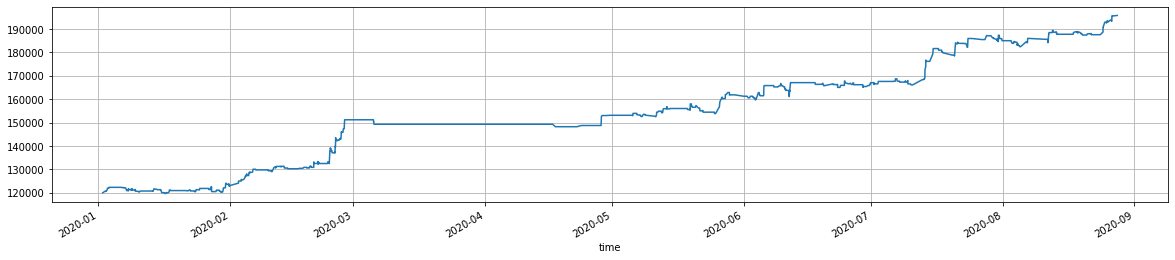

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     86
 NQ    588
 YM    140
 Name: action, dtype: int64,
 814)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.500000
 NQ    3.418605
 YM    0.813953
 Name: action, dtype: float64,
 4.732558139534884)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     180.6
NQ    1234.8
YM     294.0
Name: commission, dtype: float64

In [16]:
df.commission.sum()

1709.4000000000005

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.43,98.37,687.14,-349.38,1.97,96.32,294.0
YM,0.54,376.73,1134.62,-523.26,2.17,372.00,70.0
ES,0.47,477.49,1680.18,-568.33,2.96,488.47,43.0
total,0.45,186.30,886.41,-397.13,2.23,180.46,407.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,NQ,YM,total
contract,,,,
ES,1.000000,0.097449,0.329967,0.670112
NQ,0.097449,1.000000,0.049024,0.684747
YM,0.329967,0.049024,1.000000,0.613088
total,0.670112,0.684747,0.613088,1.000000


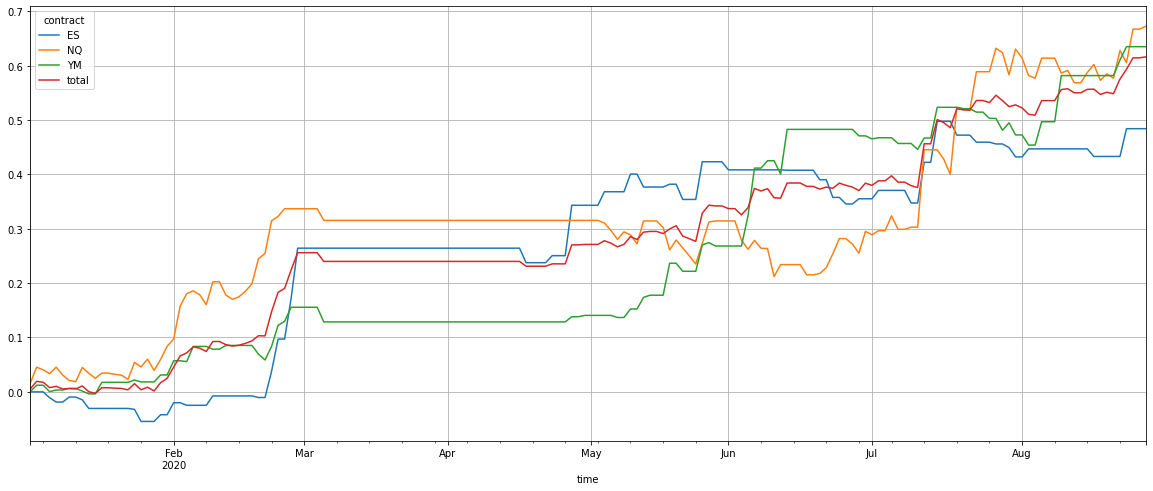

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

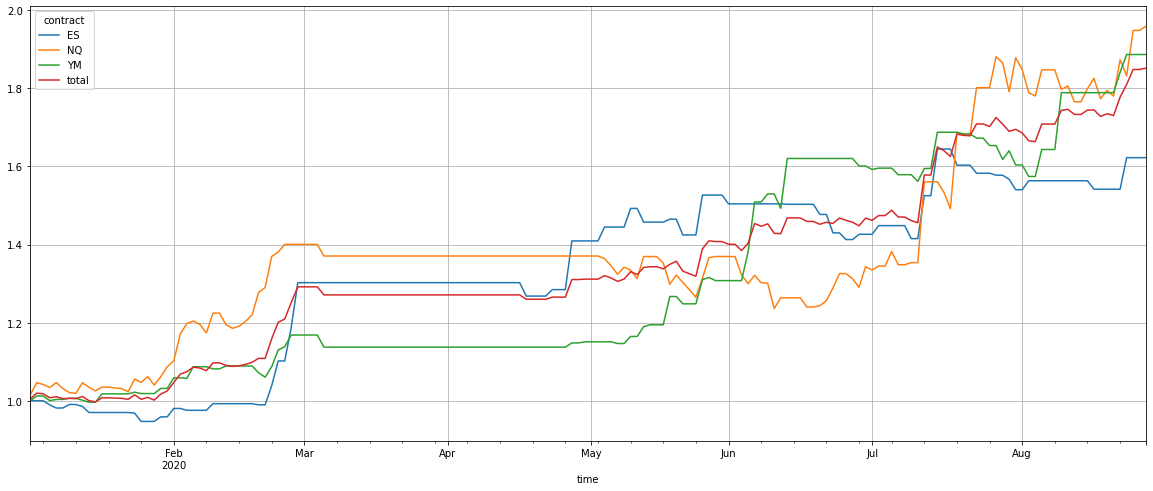

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,NQ,YM,total
Annual return,1.032231,1.679413,1.534832,1.466586
Cumulative returns,0.622572,0.959540,0.886737,0.851916
Annual volatility,0.296273,0.387938,0.266654,0.209527
Sharpe ratio,2.538335,2.730553,3.622357,4.418280
Calmar ratio,13.819274,14.314066,22.875128,40.744817
Stability,0.832617,0.677400,0.895077,0.944461
Max drawdown,-0.074695,-0.117326,-0.067096,-0.035994
Omega ratio,2.570726,1.925067,3.583670,2.996012
Sortino ratio,7.693519,6.524618,12.571830,14.377767
Skew,3.151305,2.500468,3.081799,2.477306


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,NQ,YM,total
time,,,,
2020-01-31,-4.12,8.74,3.16,2.52
2020-02-29,35.84,28.79,13.26,25.99
2020-03-31,0.00,-2.12,-2.66,-1.59
2020-04-30,8.21,0.00,1.21,3.18
2020-05-31,8.34,-0.09,13.61,7.34
2020-06-30,-6.58,-1.90,22.45,4.27
2020-07-31,8.00,39.83,0.17,15.49
2020-08-31,5.33,4.32,17.62,9.25


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES       62.0
NQ       96.0
YM       89.0
total    85.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-07-20 21:50:00,NQ,SELL,10957.25,5635.8
2020-04-28 11:50:30,ES,SELL,2900.00,3883.3
2020-02-28 00:01:00,ES,BUY,2942.50,3858.3
2020-06-05 18:15:30,YM,SELL,27138.00,3685.8
2020-08-11 20:36:00,YM,SELL,27911.00,3540.8
...,...,...,...,...
2020-04-17 15:32:00,ES,SELL,2842.25,-1054.2
2020-03-05 21:50:30,YM,BUY,26161.00,-1064.2
2020-05-28 15:37:30,YM,SELL,25519.00,-1084.2


In [26]:
daily.sort_values('total', ascending=False)

contract,ES,NQ,YM,total
time,,,,
2020-07-13,0.077707,0.152890,0.021145,0.083914
2020-05-26,0.071770,0.038415,0.049645,0.053277
2020-07-15,0.078332,0.000000,0.058145,0.045493
2020-02-24,0.049270,0.061785,0.025185,0.045413
2020-02-25,0.061145,0.008265,0.039685,0.036365
...,...,...,...,...
2020-07-07,0.000000,-0.024460,-0.010480,-0.011647
2020-08-04,0.014895,-0.031960,-0.018480,-0.011848
2020-03-05,0.000000,-0.021210,-0.026605,-0.015938
